In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32') / 255.
train_images = np.expand_dims(train_images, -1)

test_images = test_images.astype('float32') / 255.
test_images = np.expand_dims(test_images, -1)

# Define the sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Encoder model
latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = BatchNormalization()(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# VAE model
z_mean, z_log_var, z = encoder(encoder_inputs)
reconstructed = decoder(z)
vae = Model(encoder_inputs, reconstructed, name="vae")

# Add KL divergence to the loss
kl_loss = -0.5 * tf.reduce_sum(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=1)
vae.add_loss(tf.reduce_mean(kl_loss) / 784.0)

# Compile the model
optimizer = Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer, loss=MeanSquaredError())

# Train the model
history = vae.fit(
    train_images,
    train_images,
    epochs=50,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/50
422/422 [==============================] - 74s 161ms/step - loss: 0.0549 - val_loss: 0.1574
Epoch 2/50
422/422 [==============================] - 61s 143ms/step - loss: 0.0415 - val_loss: 0.0409
Epoch 3/50
422/422 [==============================] - 61s 144ms/step - loss: 0.0397 - val_loss: 0.0391
Epoch 4/50
422/422 [==============================] - 61s 143ms/step - loss: 0.0389 - val_loss: 0.0392
Epoch 5/50
422/422 [==============================] - 61s 144ms/step - loss: 0.0383 - val_loss: 0.0385
Epoch 6/50
422/422 [==============================] - 60s 143ms/step - loss: 0.0378 - val_loss: 0.0384
Epoch 7/50
422/422 [==============================] - 60s 143ms/step - loss: 0.0376 - val_loss: 0.0376
Epoch 8/50
422/422 [==============================] - 60s 142ms/step - loss: 0.0373 - val_loss: 0.0378
Epoch 9/50
422/422 [==============================] - 61s 143ms/step - loss: 0.0372 - val_loss: 0.0374
Epoch 10/50
422/422 [==============================] - 61s 144ms/step - l

1/1 [==============================] - 0s 23ms/step


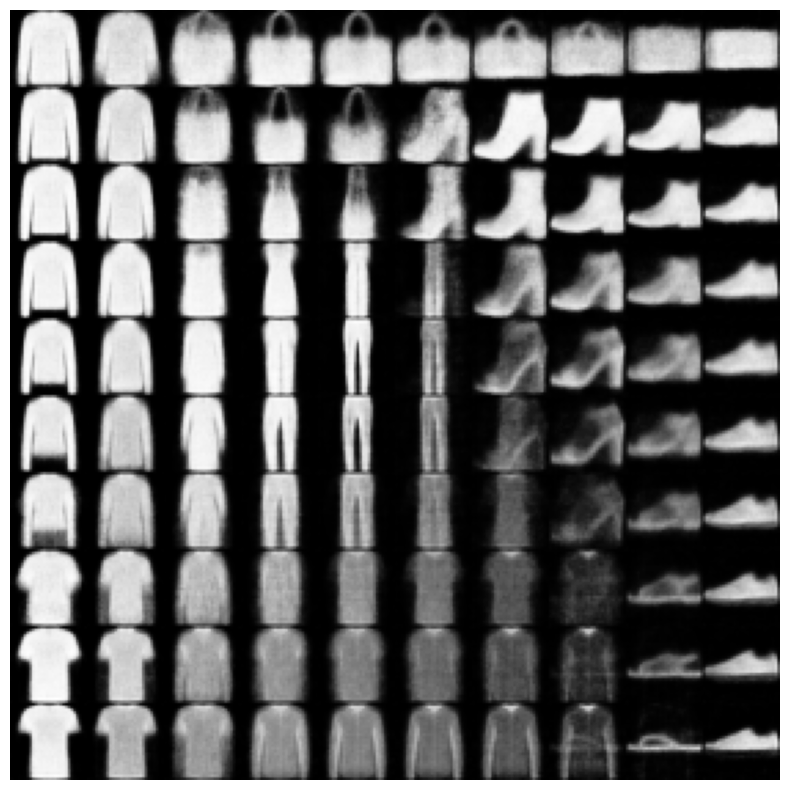

313/313 [==============================] - 1s 3ms/step


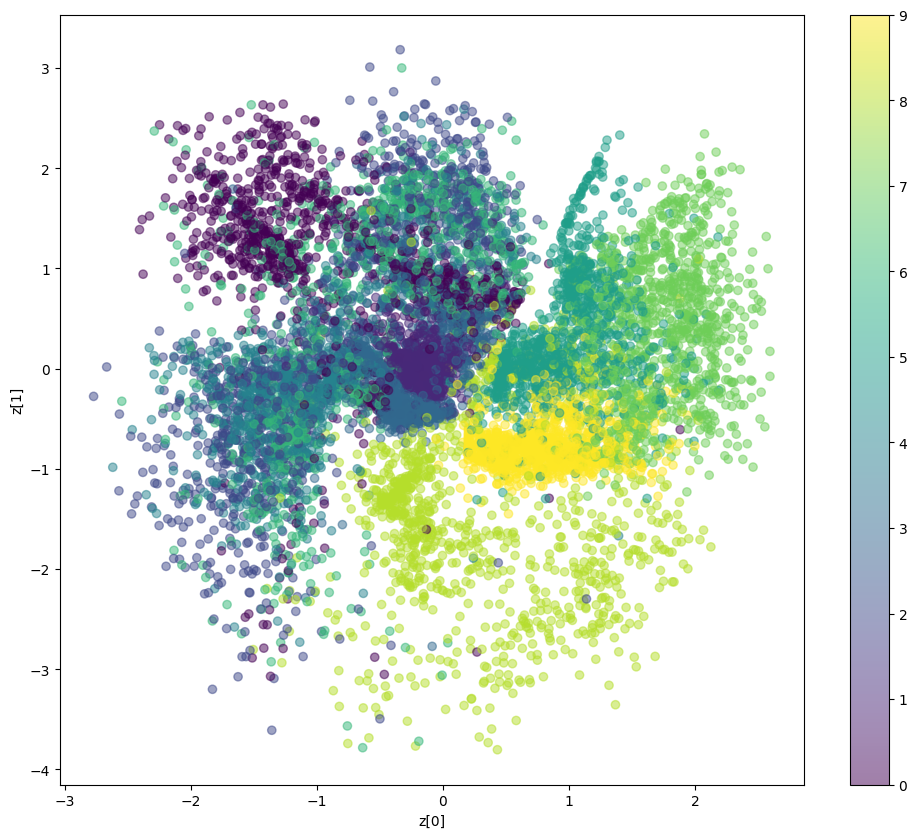

In [ ]:
# Display the generated images
def display_images(decoder, n=10, figure_size=28):
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  figure = np.zeros((figure_size * n, figure_size * n))

  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(figure_size, figure_size)
          figure[i * figure_size:(i + 1) * figure_size,
                  j * figure_size:(j + 1) * figure_size] = digit

  plt.figure(figsize=(10, 10))
  plt.imshow(figure, cmap='Greys_r')
  plt.axis('Off')
  plt.show()
display_images(decoder)

# Visualize the latent space
def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, alpha=0.5, cmap='viridis')
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.show()

plot_label_clusters(encoder, test_images, test_labels)